<a href="https://colab.research.google.com/github/maniceet/How-do-you-like-them-Apples/blob/master/How_do_you_like_them_apples_(Model_Training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing Packages
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import re, string, unicodedata
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from functools import reduce
from fastai.text import *
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
#Defining class to read txt file by paragraphs rather than by line
class ByParagraph:


    def __init__(self, text):
        self.text = text


    def __iter__(self):
        return self
        par = ""


    def __next__(self):
        par = []
        for line in self.text:
            if line.isspace():
                break
            par.append(line.strip())
        else:
            if not par:
                raise StopIteration()
        return ' '.join(par)


In [0]:
# Adding all paragraphs to a list for apple computers txt
apple_computers = []
with open('apple-computers.txt',"r", encoding="utf8") as f:
  for par in ByParagraph(f):
        if par == "":
            continue
        else:
            apple_computers.append(par)

In [0]:
# Adding all paragraphs to a list for apple fruit txt
apple_fruits = []
with open('apple-fruit.txt',"r", encoding="utf8") as f:
  for par in ByParagraph(f):
        if par == "":
            continue
        else:
            apple_fruits.append(par)

In [5]:
#Creating Training Data Frame
label = ['computer-company']*len(apple_computers) + ['fruit']*len(apple_fruits)
text = apple_computers + apple_fruits

df = pd.DataFrame(list(zip(text, label)), columns=['text', 'label'])
print(df.shape)

(83, 2)


In [6]:
df.head()

,text,label
0,"Apple Inc. From Wikipedia, the free encycloped...",computer-company
1,"The Apple I, Apple's first product, was sold a...",computer-company
2,"Apple's ""1984"" television ad, set in a dystopi...",computer-company
3,"The first Macintosh, released in 1984 In 1984,...",computer-company
4,"The Macintosh Portable was Apple's first ""port...",computer-company


Paragraph Length: 
Mean 2485.65 words (median - 2033.000000)


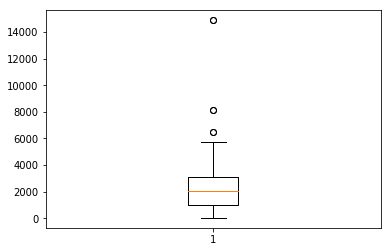

In [7]:
# Summarize Paragraph length
print("Paragraph Length: ")
result = [len(text) for text in df.text]
print("Mean %.2f words (median - %f)" % (np.mean(result), np.median(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [0]:
#Cleaning Training Data

#Remove HTML Tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
r_html = lambda x: strip_html_tags(x)

#Remove accented characters

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

r_accented = lambda x: remove_accented_chars(x)

#Expand Contractions

from contraction import expand_contractions
expand = lambda x: expand_contractions(x)


#Remove special characters

def remove_special_characters(text, remove_digits=False):
    #text = text.lower()
    text = re.sub('\w*\d\w*', '', text) #Removing words that have numbers in them
    pattern = r'[^a-zA-z0-9.\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[''""_]' #Removing punctuations and underscores
    text = re.sub(pattern, '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)   #Removing characters that appear more than twice
    text = re.sub(r'\[', "",text)
    text = re.sub(r'\]', "",text)
    text = text.replace('\t', ' ')
    return text

In [0]:
functions = [strip_html_tags, remove_accented_chars, expand_contractions, remove_special_characters]

for fun in functions:
    df['text'] = df['text'].apply(fun)

In [0]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size = 0.25, stratify = df['label'])

In [11]:
train_df.head()

,text,label
31,MacBook Air Main article Macintosh See also Ti...,computer-company
48,Brita as Iduna by Carl Larsson Germanic pagan...,fruit
19,Global Taxes Paid by ASI Apple created subsid...,computer-company
67,Main article Apple symbolism,fruit
62,Apples with skin edible parts Nutritional valu...,fruit


In [12]:
valid_df.head()

,text,label
1,The Apple I Apples first product was sold as a...,computer-company
73,Apple pot In the wild apples grow readily from...,fruit
25,The Macintosh Portable was Apples first portab...,computer-company
78,See also Cooking apple and Cider apple,fruit
58,See also Cooking apple and Cider apple,fruit


Training Language Model

In [0]:
path = os.getcwd()

In [0]:
bs = 16
# Language model data
data_lm = TextLMDataBunch.from_df(path = os.getcwd(),train_df = train_df, valid_df = valid_df, text_cols= 'text', label_cols= 'label')

data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [16]:
data_lm.show_batch()

idx,text
0,in . imac xxmaj consumer allin one desktop computer introduced in . xxmaj mac xxmaj pro xxmaj workstation desktop computer introduced in . xxmaj apple sells a variety of computer accessories for xxmaj macs including xxmaj thunderbolt xxmaj display xxmaj magic xxmaj mouse xxmaj magic xxmaj trackpad xxmaj wireless xxmaj keyboard xxmaj battery xxmaj charger the airport wireless networking products and xxmaj time xxmaj capsule . ipad xxmaj main article
1,first . xxmaj lisa won the race in and became the first personal computer sold to the public with a xxup gui but was a commercial failure due to its high price tag and limited software titles . xxbos xxmaj organic xxmaj jonathan apples sitting in a sink strainer after being washed . xxmaj organic apples are commonly produced in the xxmaj united xxmaj states . xxmaj organic production is
2,braeburn xxmaj capital and filemaker xxmaj inc. xxmaj during the xxmaj macs early history xxmaj apple generally refused to adopt prevailing industry standards for hardware instead creating their own . xxmaj this trend was largely reversed in the late beginning with xxmaj apples adoption of the xxup pci bus in the xxmaj power xxmaj macs . xxmaj apple has since adopted xxup usb xxup agp hypertransport wifi and other industry
3,in the xxup xxunk is no longer a xxunk option for most xxmaj apple products . xxmaj xxunk other major xxup us companies xxmaj apple has a relatively simple xxunk policy for executives which does not include xxunk that other ceos xxunk such as country club xxunk and xxunk use of company xxunk . xxmaj the company usually xxunk stock xxunk to executives every other year . a media article
4,macintosh would need to be replaced by a new platform or xxunk to run on more powerful hardware . xxmaj in xxmaj apple xxunk with xxup ibm and xxmaj motorola in the xxup aim alliance . xxmaj the goal was to create a new computing platform the powerpc xxmaj reference xxmaj platform which would use xxup ibm and xxmaj motorola hardware xxunk with xxmaj apples software . xxmaj the xxup


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


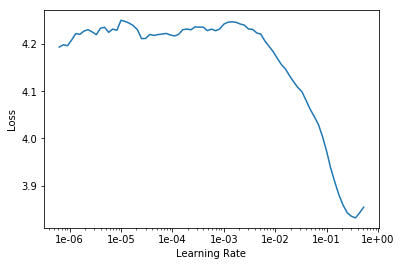

In [42]:
learn.recorder.plot(skip_end=15)

In [43]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.948859,3.401356,0.326607,00:01


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.217925,3.148783,0.364375,00:02
1,2.861207,2.402925,0.488929,00:02
2,2.139214,1.455081,0.685000,00:02
3,1.456442,0.824021,0.838304,00:02
4,0.962808,0.733700,0.863482,00:02


In [0]:

learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "Apple macintosh is "
N_WORDS = 40
N_SENTENCES = 2

In [53]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Apple macintosh is  the first model offered by Sprint joining IBM and Verizon Wireless as the United States carriers offering iphone models . On October Apple announced an agreement with c Spire
Apple macintosh is  a traditional display of an apple that is . The original ipad was released on November alongside the iphone and iphone . It was released on April with a reduced price of for the GB


In [0]:
learn.save_encoder('fine_tuned_enc')

Training Classifier

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = os.getcwd(), train_df = train_df, valid_df = valid_df, text_cols= 'text', label_cols= 'label', classes = ['computer-company', 'fruit'], bs=16)

In [56]:
data_clas.save('data_clas.pkl')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj company headquarters on xxmaj infinite xxmaj loop in xxmaj cupertino xxmaj california xxmaj apple xxmaj xxunk world corporate headquarters are located in the middle of xxmaj silicon xxmaj xxunk at xxmaj infinite xxmaj loop xxmaj cupertino xxmaj california . xxmaj this xxmaj apple campus has six buildings that total square feet and was built in by xxmaj xxunk xxmaj development xxmaj xxunk . xxmaj in xxmaj apple announced,computer-company
xxbos xxmaj apple store in xxmaj yonkers xxmaj new xxmaj york xxmaj on xxmaj january xxmaj jobs announced in an internal xxmaj apple memo that he would take another medical leave of absence for an indefinite period to allow him to focus on his health . xxmaj chief operating officer xxmaj tim xxmaj cook assumed xxmaj jobs daytoday operations at xxmaj apple although xxmaj jobs would still remain involved in,computer-company
xxbos xxmaj apple store in xxmaj yonkers xxmaj new xxmaj york xxmaj on xxmaj january xxmaj jobs announced in an internal xxmaj apple memo that he would take another medical leave of absence for an indefinite period to allow him to focus on his health . xxmaj chief operating officer xxmaj tim xxmaj cook assumed xxmaj jobs daytoday operations at xxmaj apple although xxmaj jobs would still remain involved in,computer-company
xxbos xxmaj the macbook xxmaj pro xxmaj apples first laptop with an xxmaj intel xxunk announced in xxmaj january . xxmaj at the xxmaj worldwide xxmaj developers xxmaj conference keynote xxunk on xxmaj june xxmaj steve xxmaj jobs announced that xxmaj apple would begin producing xxmaj xxunk xxmaj mac computers in . xxmaj on xxmaj january the new macbook xxmaj pro and imac became the first xxmaj apple computers to,computer-company
xxbos xxmaj the original iphone and to scale . xxmaj main article iphone xxmaj at the xxmaj macworld xxmaj conference xxmaj expo in xxmaj january xxmaj steve xxmaj jobs introduced the longanticipated iphone a convergence of an xxmaj internetenabled smartphone and ipod . xxmaj the original iphone was released on xxmaj june for xxup gb and xxup gb with an xxup att contract . xxmaj on xxmaj february it was,computer-company


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [58]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


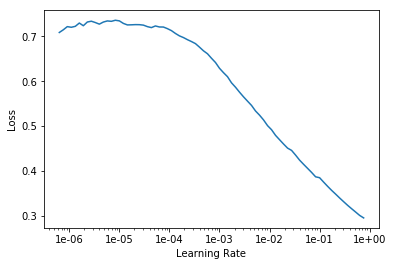

In [59]:
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.702560,0.678393,0.952381,00:02


In [0]:
learn.save('first')


In [0]:
learn.load('first');

In [63]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.374291,0.529454,0.952381,00:03


In [0]:
learn.save('second')


In [0]:
learn.load('second');

In [66]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.299674,0.472925,1.000000,00:03


In [0]:
learn.save('third')


In [0]:
learn.load('third');

In [198]:
# learn.unfreeze()
# learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.389138,0.235811,1.000000,00:06
1,0.329412,0.198821,1.000000,00:06


In [0]:
learn.save('fine_tuned_classifier')

In [0]:
learn.export('trained_model.pkl')

Checking Model Performance

In [74]:
learn.predict("When Steve Jobs stepped down as Apple's CEO in August 2011, people said it was the end of an era. The departure of Apple design chief Jony Ive, announced Thursday, is the latest sign of the new Apple. \
For the past couple of decades, Apple has gone through one of the most dramatic resurgences in history. Its tale of dramatic rise under co-founder Jobs, its decline and near death after his ouster, and then its rebirth are the stuff of Silicon Valley legend")

(Category computer-company, tensor(0), tensor([0.6051, 0.3949]))

In [75]:
learn.predict('ve and Jobs were close friends, bonding over frequent lunches and a similar sensibility for design. "We on the first meeting, in a quite shocking way, really did click," Ive said in a rare interview in 2017. "We just established an immediate understanding."')

(Category computer-company, tensor(0), tensor([0.5389, 0.4611]))

In [76]:
learn.predict('The departure of Ive, whose soft, British voice introduced Apple hardware in countless sizzle reels, is the latest sign of major shifts within Apple. The company grew to become one of the worlds most profitable and highly valued companies, worth nearly $1 trillion, on the back of the iPhone.')

(Category computer-company, tensor(0), tensor([0.6135, 0.3865]))

In [77]:
learn.predict('The gardens of Kashmir have the best Apples grown all over the world')

(Category fruit, tensor(1), tensor([0.4949, 0.5051]))

In [78]:
learn.predict('The best screen ever in a Phone, Apples Iphone is also very expensive. Steve Jobs was overtaken by Tim Cook')

(Category computer-company, tensor(0), tensor([0.5428, 0.4572]))

In [79]:
learn.data.batch_size

16

In [80]:
learn.predict("""If this seems a bit like déjà vu, you’ll recall that Apple just held an event to unveil two
new iPhone models – the 5c and 5s – back on September 10.""")

(Category computer-company, tensor(0), tensor([0.5425, 0.4575]))

In [0]:
test_df = df
learn.data.add_test(test_df['label'])
prob_preds = learn.get_preds(ds_type=DatasetType.Test, ordered=True)

In [82]:
learn.predict('Apple is a software company based in California')

(Category computer-company, tensor(0), tensor([0.5309, 0.4691]))

In [86]:
learn.predict("""Fortunately, there are “low-chill” apple varieties for temperate climates. (Chilling hours
are defined as nonconsecutive hours of winter temperatures below 45 degrees.) As a
general guide, if you live on or near the coast, your garden gets only 100 to 200 chilling
hours. Inland San Diego gardens get about 400 to 500 chilling hours — still considered
“low chill.”""")

(Category fruit, tensor(1), tensor([0.3684, 0.6316]))

In [87]:
learn.predict("""Apple already plans to buy back `$100 billion in shares, including $`16 billion worth last
quarter. Icahn probably pounded the dinner table he and Cook shared recently for their
much-reported bread-breaking at Icahn's New York apartment. Apple's cash stash
currently sits at a whopping `$145 billion but only $`43 billion is in the U.S., which is why
Icahn wants to float bonds to cover a buyback""")

(Category computer-company, tensor(0), tensor([0.6032, 0.3968]))

In [85]:
learn.predict(valid_df['text'].iloc[0])

(Category computer-company, tensor(0), tensor([0.6511, 0.3489]))